# Tutorial 6 - Creating a Segmentation U-Net

This tutorial follows up on Tutorial 5 from qtim_Tutorials. We will be transforming the network made in that tutorial into a segmentation network, by modifying our preprocessing steps and neural network architecture.

# Mounting your Google Drive

Running these two blocks of code will give the Colab environment access to your data on Google Drive. If you aren't comfortable with this idea, I'd suggest making a new Drive account dedicated to this project!

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

Let's navigate to the folder where our data is stored and check everything is there:

In [9]:
import os
os.chdir('MGH/Teaching/training')
!ls

/content/drive
BRATS_10_Updated  segmentation_network.ipynb  training_segmentation_nonorm.h5
old		  training_segmentation.h5


# Installing Prerequisite Packages

Some of the code we're running requires other packages to be installed. You can install them to Colab using the following pip install commands. To run a bash command in Colab, prepend it with a "!".

In [10]:
!pip install nibabel

    100% |████████████████████████████████| 4.2MB 10.2MB/s 
  Running setup.py bdist_wheel for nibabel ... - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/7e/97/9b/7cf05225afac39de2dacef758fc06c0c0bdf3e6efb40fabb9c
Successfully built nibabel


# Preprocessing Our Data (again)

When we first preprocessed our data, we preprocessed it for the MR slice classification case. This meant that we took ground truth slices and assigned them a "0" or "1" value depending on whether they contained tumor slices or not. This time, we want to predict segmentations, not classifications, so we're going to omit the binary 0/1 classification step.

We've copied below our preprocessing steps from the previous tutorial, and made some modifications for preprocessing in "segmentation" mode, as opposed to "classification".

In [0]:
import os
import numpy as np
import nibabel as nib

def load_all_sequences_from_patients(input_directory, patient_id):

    output_arrays = []
    sequences = ['t1ce', 't1', 'flair', 't2', 'seg']
    
    for sequence in sequences:
        target_file = os.path.join(input_directory, patient_id, patient_id + '_' + sequence + '.nii.gz')
        data_array = nib.load(target_file).get_data()
        output_arrays.append(data_array)
    
    stacked_output_array = np.stack(output_arrays[0:4], axis=-1)
    ground_truth_array = np.expand_dims(output_arrays[-1], axis=-1)    
    return stacked_output_array, ground_truth_array

  
def split_3d_array_into_2d_slices(input_array, skip=20, binarize=True):
    
    total_axial_slices = input_array.shape[2]
    output_slices = list()
    
    for current_axial_num in range(skip, total_axial_slices-skip):
        
        extracted_slice = input_array[:, :, current_axial_num, :]
        if binarize:
          extracted_slice[extracted_slice > 0] = 1
        
        output_slices.append(extracted_slice)
        
    return output_slices

def assign_ground_truth_from_slices(input_ground_truth_slices):
    
    ground_truth_labels = list()
    
    for ground_truth_slice in input_ground_truth_slices:
        
        if np.sum(ground_truth_slice) > 0:
            ground_truth_labels.append(1)
        else:
            ground_truth_labels.append(0)
        
    return ground_truth_labels

def normalize_images(input_3d_data):
        
    number_of_channels = input_3d_data.shape[-1]
    normalized = []
    
    for channel in range(number_of_channels):
        
        extracted_channel = input_3d_data[:, :, :, channel].copy()

        masked_channel = np.copy(extracted_channel)
        masked_channel[masked_channel == 0] = -100
        masked_channel = np.ma.masked_where(masked_channel == -100, masked_channel)

        masked_channel = masked_channel - np.mean(masked_channel)
        masked_channel = masked_channel / np.std(masked_channel)
        
        normalized.append(masked_channel.astype('float16'))
        
    return np.stack(normalized, axis=3)

def generate_dataset(data_directory, patient_data_list, mode="segmentation"):

    X, y = [], [] 

    for patient_directory in patient_data_list:

        print('Working on...', patient_directory)
      
        # Load nifti files for MR sequences and tumor segmentation
        patient_sequences, ground_truth = load_all_sequences_from_patients(data_directory, patient_directory)

        # Normalize input volumes
#         patient_norm = normalize_images(patient_sequences)  # this is a new addition too
        patient_norm = patient_sequences

        # 4D volumes to slices
        sequence_slices = split_3d_array_into_2d_slices(patient_norm, binarize=False)  # don't binarize your inputs
        ground_truth_slices = split_3d_array_into_2d_slices(ground_truth, binarize=True)  # binarize these

        # Get ground truth vector
        if mode == "classification":
          ground_truth_vector = assign_ground_truth_from_slices(ground_truth_slices)
        elif mode == "segmentation":
          
          # ground_truth_slices[ground_truth_slices > 0] = 1          
          ground_truth_vector = ground_truth_slices

        # Append this patient to our lists
        X.append(sequence_slices)
        y.append(ground_truth_vector)

    X = np.asarray(X)
    # (1000, 240, 240, 4)
    
    if mode == "classification":
        y = np.hstack(y)
    elif mode == "segmentation":
        y = np.array(y)
    
    # Grab the dimensions of the 5D array
    patients, slices, rows, cols, ch = X.shape

    # Combine the first two dimension (patients, slices) into one
    X = X.reshape(patients*slices, rows, cols, ch)
    
    if mode == 'segmentation':
      patients, slices, rows, cols, ch = y.shape
      y = y.reshape(patients * slices, rows, cols, ch)
    
    return X, y

In [24]:
input_directory = 'BRATS_10_Updated'
test_patient = 'Brats17_2013_0_1'

patient_data_list = os.listdir(input_directory)

X, y = generate_dataset(input_directory, patient_data_list, mode='segmentation')

Working on... Brats17_2013_18_1
Working on... Brats17_2013_2_1
Working on... Brats17_2013_7_1
Working on... Brats17_2013_0_1
Working on... Brats17_2013_5_1
Working on... Brats17_2013_6_1
Working on... Brats17_2013_4_1
Working on... Brats17_2013_1_1
Working on... Brats17_2013_3_1
Working on... Brats17_2013_8_1
Working on... Brats17_2013_9_1


In [0]:
import h5py  # python package 
import numpy as np

def save_hdf5_file(train_data, ground_truth, output_filename):
    
    with h5py.File(output_filename, 'w') as file_handle:

        file_handle.create_dataset('train', data=train_data, dtype=train_data.dtype)
        file_handle.create_dataset('labels', data=ground_truth, dtype=ground_truth.dtype)


In [12]:
!ls

BRATS_10_Updated  segmentation_network.ipynb  training_segmentation_nonorm.h5
old		  training_segmentation.h5


In [28]:
print('Input data shape', X.shape)
print('Ground data shape', y.shape)

# patients, slices, rows, cols, ch = y.shape
# y_fixed = y.reshape(patients * slices, rows, cols, ch)

# print('New Ground truth data shape', y_fixed.shape)

output_filename = 'training_segmentation_nonorm2.h5'
save_hdf5_file(X, y, output_filename)

Input data shape (1265, 240, 240, 4)
Ground data shape (1265, 240, 240, 1)


In [27]:
# Check to see if we have our new h5 file.
!ls

BRATS_10_Updated  old			      training_segmentation.h5
drive		  segmentation_network.ipynb


# Implementing our Network (and upgrading it to the full U-Net)

In [0]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Flatten, UpSampling2D, Concatenate
from keras.layers.pooling import GlobalAveragePooling2D
from keras.models import Model


def make_model(max_channels=1024, mode='segmentation'):

    # First block
    input_layer = Input(shape=(240, 240, 4))
    conv1_1 = Conv2D(max_channels // 16, (3, 3), padding='same', activation='relu')(input_layer)
    conv1_2 = Conv2D(max_channels // 16, (3, 3), padding='same', activation='relu')(conv1_1)
    bn1 = BatchNormalization()(conv1_2)   # "preprocessing" each layer of the network
    pool1 = MaxPool2D((2, 2))(bn1)

    # Second block
    conv2_1 = Conv2D(max_channels // 8, (3, 3), padding='same', activation='relu')(pool1)
    conv2_2 = Conv2D(max_channels // 8, (3, 3), padding='same', activation='relu')(conv2_1)
    bn2 = BatchNormalization()(conv2_2)
    pool2 = MaxPool2D((2, 2))(bn2)

    # Third block
    conv3_1 = Conv2D(max_channels // 4, (3, 3), padding='same', activation='relu')(pool2)
    conv3_2 = Conv2D(max_channels // 4, (3, 3), padding='same', activation='relu')(conv3_1)
    bn3 = BatchNormalization()(conv3_2)
    pool3 = MaxPool2D((2, 2))(bn3)

    # Fourth block
    conv4_1 = Conv2D(max_channels // 2, (3, 3), padding='same', activation='relu')(pool3)
    conv4_2 = Conv2D(max_channels // 2, (3, 3), padding='same', activation='relu')(conv4_1)
    bn4 = BatchNormalization()(conv4_2)
    pool4 = MaxPool2D((2, 2))(bn4)

    # Fifth block
    conv5_1 = Conv2D(max_channels, (3, 3), padding='same', activation='relu')(pool4)
    conv5_2 = Conv2D(max_channels, (3, 3), padding='same', activation='relu')(conv5_1)
    bn5 = BatchNormalization()(conv5_2)

    if mode == 'segmentation':
      
        # Sixth block
        upsample1 = UpSampling2D((2, 2))(bn5)
        concatenate1 = Concatenate(axis=3)([upsample1, bn4])
        conv6_1 = Conv2D(max_channels // 2, (3, 3), padding='same', activation='relu')(concatenate1)
        conv6_2 = Conv2D(max_channels // 2, (3, 3), padding='same', activation='relu')(conv6_1)
        bn6 = BatchNormalization()(conv6_2)
        
        # Seventh block
        upsample2 = UpSampling2D((2, 2))(bn6)
        concatenate2 = Concatenate(axis=3)([upsample2, bn3])
        conv7_1 = Conv2D(max_channels // 4, (3, 3), padding='same', activation='relu')(concatenate2)
        conv7_2 = Conv2D(max_channels // 4, (3, 3), padding='same', activation='relu')(conv7_1)
        bn7 = BatchNormalization()(conv7_2)
                
        # Eighth block
        upsample3 = UpSampling2D((2, 2))(bn7)
        concatenate3 = Concatenate(axis=3)([upsample3, bn2])
        conv8_1 = Conv2D(max_channels // 8, (3, 3), padding='same', activation='relu')(concatenate3)
        conv8_2 = Conv2D(max_channels // 8, (3, 3), padding='same', activation='relu')(conv8_1)
        bn8 = BatchNormalization()(conv8_2)
        
        # Ninth block
        upsample4 = UpSampling2D((2, 2))(bn8)
        concatenate4 = Concatenate(axis=3)([upsample4, bn1])
        conv9_1 = Conv2D(max_channels // 16, (3, 3), padding='same', activation='relu')(concatenate4)
        conv9_2 = Conv2D(max_channels // 16, (3, 3), padding='same', activation='relu')(conv9_1)
        bn9 = BatchNormalization()(conv9_2)
        
        # Segmentation
        output = Conv2D(1, (1, 1), activation='sigmoid')(bn9)
        
    if mode == 'classification':
      
      # flatten = Flatten()(conv10)
      pool5 = GlobalAveragePooling2D()(conv10)

      # Fully-connected
      dense1 = Dense(128, activation='relu')(flatten)
      drop1 = Dropout(0.5)(dense1)
      output = Dense(1, activation='sigmoid')(drop1)

    # Create model object
    model = Model(inputs=input_layer, outputs=output)
    print(model.summary())

    return model

In [14]:
model = make_model(mode='segmentation')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

# Data generators

Keras provides powerful tools for iterating over datasets and augmenting them in real-time. In just a few lines of code, we can define a generator that yields random batches of the data (without ever loading all of it into memory) with randomly applied transformations. This serves to diversify the dataset and hopefully make the resulting model more generalizable.

In [0]:
import h5py

data = h5py.File('training_segmentation_nonorm2.h5')

X = data['train']
Y = data['labels']


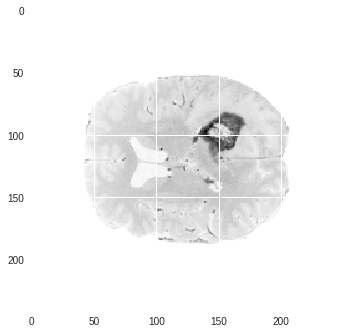

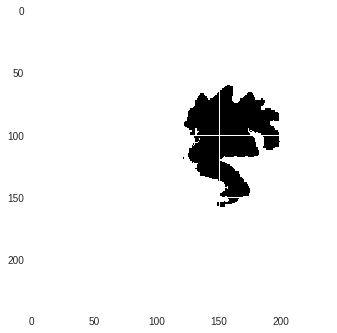

In [30]:
import matplotlib.pyplot as plt
plt.imshow(X[64, :, :, 0])
plt.show()
plt.imshow(Y[64, :, :, 0])
plt.show()

In [0]:
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.io_utils import HDF5Matrix
seed = 0
batch_size = 15

data_gen_args = dict( 
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90
)

X_train = HDF5Matrix('training_segmentation_nonorm2.h5', 'train')
Y_train = HDF5Matrix('training_segmentation_nonorm2.h5', 'labels')

X_datagen = ImageDataGenerator(**data_gen_args)
X_generator = X_datagen.flow(X_train, seed=seed, batch_size=batch_size, shuffle=False)

Y_datagen = ImageDataGenerator(**data_gen_args)
Y_generator = Y_datagen.flow(Y_train, seed=seed, batch_size=batch_size, shuffle=False)

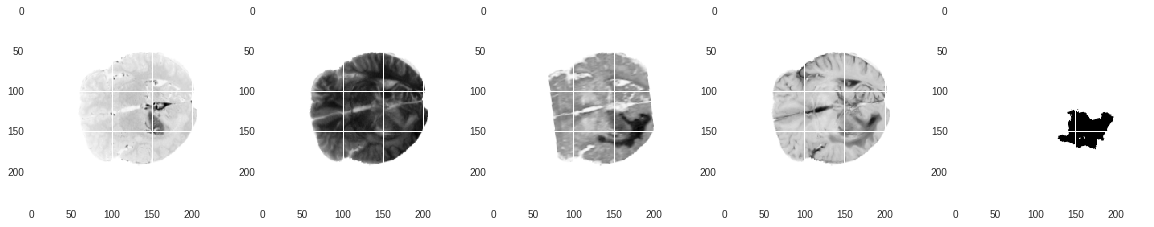

In [35]:
import matplotlib.pyplot as plt

X_batch = next(X_generator)
Y_batch = next(Y_generator)

plt.figure(figsize=(20,10))
plt.subplot(151)
plt.imshow(X_batch[0, :, :, 0])
plt.subplot(152)
plt.imshow(X_batch[0, :, :, 1])
plt.subplot(153)
plt.imshow(X_batch[0, :, :, 2])
plt.subplot(154)
plt.imshow(X_batch[0, :, :, 3])
plt.subplot(155)
plt.imshow(Y_batch[0, :, :, 0])
plt.show()


# Training the model

At long last, we can train our model! The process goes something like this:

* Initialize the network randomly, with a certain optimizer, loss function and metric
* Grab a random batch of data from the HDF5 file and randomly augment it
* Push it through the network, and get the predictions
* Calculate the error (loss)
* Calculate the partial derivative of the loss function w.r.t. each of the weights + biases, using back-propagation
* Update the network's weights in the negative direction of the gradient, multiplied by the learning rate
* Repeat until dataset is exhausted
* Run the network on the validation data, but *do not* update the network
* Repeat until convergence/fixed number of iterations (epochs) reached

We specify two 'callbacks' which are run at the end of each epoch:

* Model checkpoint: if the validation loss improves, save the model
* Early stopping: if we fail to make progress after a certain number of epochs,  stop early


In [41]:
no_samples = X_train.shape[0]
steps_per_epoch  = no_samples // batch_size
print(steps_per_epoch)

79


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc_cb = ModelCheckpoint('best_model.h5', monitor='accuracy', verbose=1)
el_cb = EarlyStopping(patience=5, monitor='accuracy')

def dice_coef():
  pass

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit_generator(zip(X_generator, Y_generator), epochs=1000, steps_per_epoch=steps_per_epoch, callbacks=[mc_cb, el_cb])
# shuffle='batch' # validation_data=val_generator) #, callbacks=[mc_cb, el_cb])
model.save('final_model.h5')

Epoch 1/1000
79/79 [==============================] - 123s 2s/step - loss: 0.2011 - acc: 0.9811

Epoch 00001: saving model to best_model.h5


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:526: RuntimeWarning: Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/1000
79/79 [==============================] - 120s 2s/step - loss: 0.1391 - acc: 0.9872

Epoch 00002: saving model to best_model.h5
Epoch 3/1000
79/79 [==============================] - 120s 2s/step - loss: 0.1053 - acc: 0.9892

Epoch 00003: saving model to best_model.h5
Epoch 4/1000
79/79 [==============================] - 120s 2s/step - loss: 0.0845 - acc: 0.9903

Epoch 00004: saving model to best_model.h5
Epoch 5/1000
 6/79 [=>............................] - ETA: 1:52 - loss: 0.0726 - acc: 0.9934

In [0]:
input_directory = 'BRATS_10_Updated'
test_patient = 'Brats17_2013_0_1'
test_data = load_all_sequences_from_patients(input_directory, test_patient)

In [51]:
X_test, Y_test = test_data
print(X_test.shape, Y_test.shape)

from keras.models import load_model

# Load our trained model
trained_model = load_model('final_model.h5')

(240, 240, 155, 4) (240, 240, 155, 1)


In [60]:
def evaluate_on_patient(model, input_volume, ground_truth):
  
  reshaped = input_volume.transpose((2, 0, 1, 3))
  Y_pred = model.predict(reshaped)
  return Y_pred
  

%timeit Y_pred = evaluate_on_patient(trained_model, X_test, Y_test)

1 loop, best of 3: 5.66 s per loop


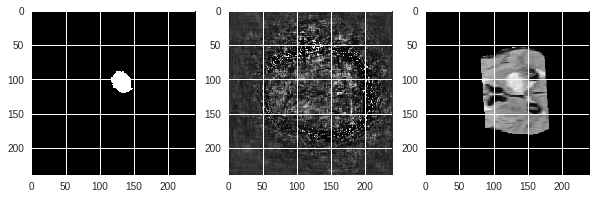

In [80]:
slice_no = Y_test.shape[2] // 2

plt.figure(figsize=(10, 30))
plt.subplot(131)
plt.imshow(Y_test[:, :, slice_no, 0] > 0, cmap='gray')
plt.subplot(132)
plt.imshow(Y_pred[slice_no, ..., 0], cmap='gray')
plt.subplot(133)
plt.imshow(X_test[:, :, slice_no, 2], cmap='gray')

In [0]:
from keras.models import load_model
import numpy as np
import h5py

model = load_model('best_model.h5')

# We will use testing data in future... this is somewhat biased!
val_data = h5py.File('validation.h5', 'r')
X_val, y_val = val_data['train'], val_data['labels']

y_pred = model.predict(X_val)  # get network predictions over entire dataset
y_true = np.asarray(y_val)  # using np.asarray explicitly loads the HDF5 data

In [0]:
import pandas as pd
pd.DataFrame([y_pred.squeeze(), y_true]).T

In [0]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# Confusion matrix, optionally normalized
normalize = False
cm = confusion_matrix(y_true, np.round(y_pred).astype('bool'))
fmt = 'd'  # for displaying the values

if normalize:
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # optional!
  fmt = '.2%'

# Use some fancy plotting
labels = ['No tumor', 'Tumor']
ax = sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.savefig('confusion.png', dpi=300)

In [0]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label='AUC: {:.2f}'.format(auc(fpr, tpr)))
plt.title('ROC analysis of my first tumor detector')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend()
plt.savefig('roc.png', dpi=300)